# Problema 1 - Utilizar RNN para prever se uma critica é positiva ou negativa considerando criticas pequenas (max 200 palavras)

In [1]:
import pandas as pd

df = pd.read_csv('./dataset/rotten_tomatoes_movie_reviews.csv')

In [2]:
df.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [3]:
df.info()


print("\nValores únicos em scoreSentiment:")
count_values = df['scoreSentiment'].value_counts()
percentages = df['scoreSentiment'].value_counts(normalize=True) * 100


pd.DataFrame({
    'Count': count_values,
    'Percentage': percentages.round(2).astype(str) + '%'
})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444963 entries, 0 to 1444962
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1444963 non-null  object
 1   reviewId        1444963 non-null  int64 
 2   creationDate    1444963 non-null  object
 3   criticName      1444963 non-null  object
 4   isTopCritic     1444963 non-null  bool  
 5   originalScore   1009745 non-null  object
 6   reviewState     1444963 non-null  object
 7   publicatioName  1444963 non-null  object
 8   reviewText      1375738 non-null  object
 9   scoreSentiment  1444963 non-null  object
 10  reviewUrl       1234038 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 111.6+ MB

Valores únicos em scoreSentiment:


,Count,Percentage
scoreSentiment,,
POSITIVE,963799,66.7%
NEGATIVE,481164,33.3%


In [4]:
df['scoreSentimentBinary'] = df['scoreSentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})

df[['scoreSentiment', 'scoreSentimentBinary']].head()

,scoreSentiment,scoreSentimentBinary
0,POSITIVE,1
1,NEGATIVE,0
2,POSITIVE,1
3,NEGATIVE,0
4,POSITIVE,1


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['reviewText'], inplace=True)
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))

short_reviews_df = df[df['word_count'] < 30]
long_reviews_df = df[df['word_count'] >= 30]

print(f"Total de críticas: {len(df)}")
print(f"Total de críticas curtas: {len(short_reviews_df)}")
print(f"Total de críticas longas: {len(long_reviews_df)}")

Total de críticas: 815199
Total de críticas curtas: 637040
Total de críticas longas: 178159


In [6]:
from sklearn.model_selection import train_test_split

x = short_reviews_df['reviewText']
y = short_reviews_df['scoreSentimentBinary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {len(x_train)}")
print(f"Tamanho do conjunto de teste: {len(x_test)}")

Tamanho do conjunto de treino: 509632
Tamanho do conjunto de teste: 127408


In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("TensorFlow version:", tf.__version__)


2025-10-04 16:56:34.109332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
Num CPUs Available:  1
TensorFlow version: 2.20.0


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import numpy as np

# Definir parâmetros
max_words = 10000  # Tamanho máximo do vocabulário
max_len = 30  # Comprimento máximo da sequência (já que estamos usando críticas curtas < 30 palavras)

# Criar e treinar o tokenizador
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

# Converter textos em sequências
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Preencher sequências para garantir comprimento uniforme
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')

# Verificar a forma dos nossos dados
print(f"Training data shape: {x_train_pad.shape}")
print(f"Testing data shape: {x_test_pad.shape}")

Training data shape: (509632, 30)
Testing data shape: (127408, 30)


In [9]:
from tensorflow.keras.layers import SimpleRNN


# Construir modelo RNN para análise de sentimento
model = Sequential([
    # Camada de Embedding para converter tokens em vetores de tamanho fixo
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    
    # Camada SimpleRNN 
    SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
    
    # Camada de saída com ativação sigmoid para classificação binária
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x_train_pad, y_train, epochs=10, batch_size=64, validation_data=(x_test_pad, y_test))
model.summary()

Epoch 1/10


/home/leonardopn/Documents/Git/UFSM/rnn-lstm-presentation/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1759607805.609865    5693 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5505 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9
2025-10-04 16:56:46.685186: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f74c8008850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-04 16:56:46.685200: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-10-04 16:56:46.735770: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-04 

  57/7963 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5764 - loss: 0.6879 

I0000 00:00:1759607809.547941    5902 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7952/7963 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6575 - loss: 0.6465

2025-10-04 16:57:08.588246: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 16:57:09.050185: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 360 bytes spill stores, 360 bytes spill loads

2025-10-04 16:57:11.014969: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 16:57:11.014990: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were fi

7963/7963 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6616 - loss: 0.6426 - val_accuracy: 0.6623 - val_loss: 0.6402
Epoch 2/10
7963/7963 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6617 - loss: 0.6413 - val_accuracy: 0.6623 - val_loss: 0.6397
Epoch 3/10
7963/7963 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6623 - loss: 0.6395 - val_accuracy: 0.6623 - val_loss: 0.6381
Epoch 4/10
7963/7963 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6629 - loss: 0.6335 - val_accuracy: 0.6672 - val_loss: 0.6296
Epoch 5/10
7963/7963 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6645 - loss: 0.6266 - val_accuracy: 0.6694 - val_loss: 0.6206
Epoch 6/10
7963/7963 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6679 - loss: 0.6204 - val_accuracy: 0.6729 - val_loss: 0.6167
Epoch 7/10
7963/7963 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6633 - loss: 0.6241 - val_accuracy: 0.6670 - val_loss: 0.6218
Epoch 8/10
7963/7963 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6676 - loss: 0.6191 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 30, 64)           │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (64, 128)              │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,501 (7.61 MB)

 Trainable params: 664,833 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,329,668 (5.07 MB)

2025-10-04 17:00:15.749590: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 17:00:16.178214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 36 bytes spill stores, 36 bytes spill loads



3982/3982 ━━━━━━━━━━━━━━━━━━━━ 4s 932us/step - accuracy: 0.6846 - loss: 0.5986
Perda de Teste: 0.5986
Precisão de Teste: 0.6846


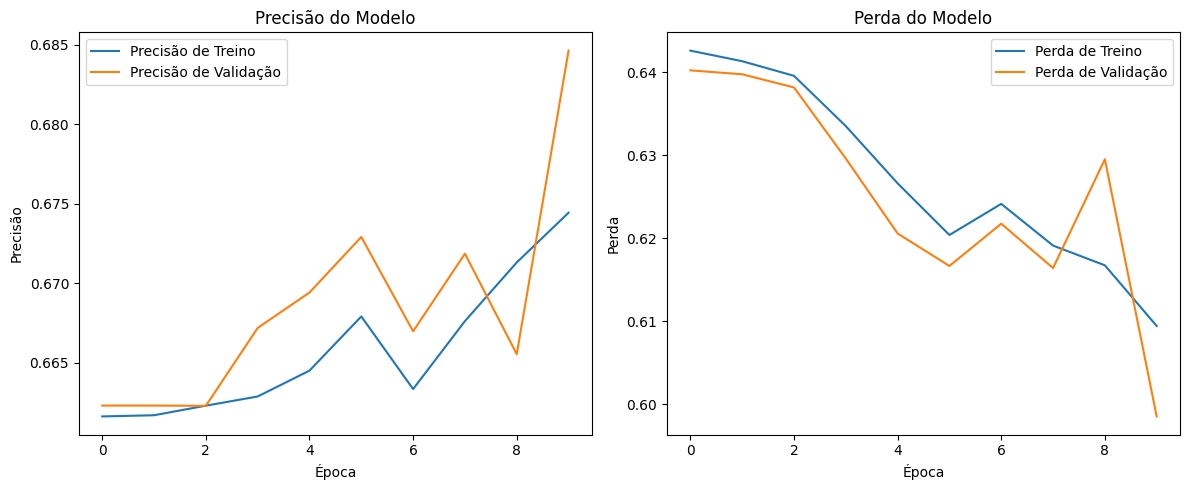


Testando modelo com exemplos de críticas:
Crítica: 'This movie was great!'
Previsto: NEGATIVO (probabilidade: 0.4288, confiança: 0.5712)
---
Crítica: 'Absolutely loved it'
Previsto: POSITIVO (probabilidade: 0.7401, confiança: 0.7401)
---
Crítica: 'Terrible film, waste of time'
Previsto: NEGATIVO (probabilidade: 0.4288, confiança: 0.5712)
---
Crítica: 'Boring and predictable'
Previsto: NEGATIVO (probabilidade: 0.4365, confiança: 0.5635)
---


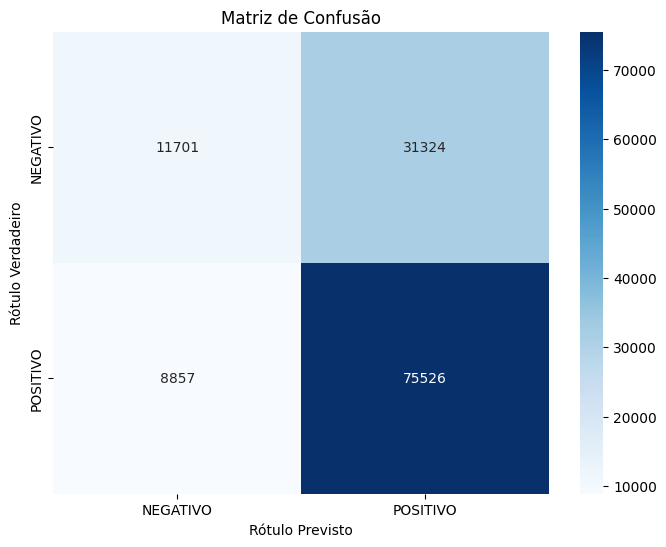


Relatório de Classificação:
              precision    recall  f1-score   support

    NEGATIVO       0.57      0.27      0.37     43025
    POSITIVO       0.71      0.90      0.79     84383

    accuracy                           0.68    127408
   macro avg       0.64      0.58      0.58    127408
weighted avg       0.66      0.68      0.65    127408



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Avaliar desempenho do modelo
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=1)
print(f"Perda de Teste: {loss:.4f}")
print(f"Precisão de Teste: {accuracy:.4f}")

# Plotar curvas de aprendizado
import matplotlib.pyplot as plt

# Verificar se o histórico do modelo está disponível e plotar curvas de aprendizado
if hasattr(model, 'history') and model.history.history:
    history = model.history.history
    
    plt.figure(figsize=(12, 5))
    
    # Plotar precisão
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Precisão de Treino')
    plt.plot(history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisão')
    plt.legend()
    
    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Perda de Treino')
    plt.plot(history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Histórico de treinamento não encontrado.")

# Função para prever sentimento para novas críticas
def predict_sentiment(text):
    # Tokenizar e preencher o texto
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Fazer previsão
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    
    # Interpretar resultado
    sentiment = "POSITIVO" if prediction > 0.5 else "NEGATIVO"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return sentiment, prediction, confidence

# Testar com exemplos de críticas
example_reviews = [
    "This movie was great!",
    "Absolutely loved it",
    "Terrible film, waste of time",
    "Boring and predictable"
]

print("\nTestando modelo com exemplos de críticas:")
for review in example_reviews:
    sentiment, prob, conf = predict_sentiment(review)
    print(f"Crítica: '{review}'")
    print(f"Previsto: {sentiment} (probabilidade: {prob:.4f}, confiança: {conf:.4f})")
    print("---")

# Criar matriz de confusão
y_pred_prob = model.predict(x_test_pad, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEGATIVO', 'POSITIVO'], yticklabels=['NEGATIVO', 'POSITIVO'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['NEGATIVO', 'POSITIVO']))
